In [41]:
# importing libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, learning_curve
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [42]:
# Set path to the current working directory
current_directory = os.getcwd()
data_path = os.path.join(current_directory, 'pointclouds-500')

# List all .xyz files in the directory
file_paths = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith('.xyz')]

In [43]:
# looping over files list to extract xyz values
point_cloud = []

for file in file_paths:
    df = pd.read_csv(file, delimiter=" ", names=['x', 'y', 'z'])
    x_values = df['x'].values
    y_values = df['y'].values
    z_values = df['z'].values
    point_cloud.append(np.column_stack((x_values, y_values, z_values)))

print(len(point_cloud))

500


Visualizing object number:  22


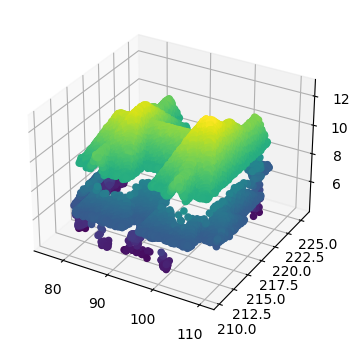

In [44]:
# visualise elements individually in 3D space
t = int(input("Object visualization query (0-99: building; 100 - 199: car; 200 - 299: fence; 300 - 399: pole; 400 - 499: tree): "))  # enter item no. for 3D vizualization
x_data = point_cloud[t][:, 0]
y_data = point_cloud[t][:, 1]
z_data = point_cloud[t][:, 2]

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_data, y_data, z_data, c=z_data, alpha=1)
print("Visualizing object number: ", t)
plt.show()

In [45]:
# lengths = []
# widths = []
# heights = []

# for item in point_cloud:
#     x = [value[0] for value in item]
#     y = [value[1] for value in item]
#     z = [value[2] for value in item]
#     min_x, max_x = np.min(x), np.max(x)
#     min_y, max_y = np.min(y), np.max(y)
#     min_z, max_z = np.min(z), np.max(z)
#     length = max_x - min_x
#     width = max_y - min_y
#     height = max_z - min_z
#     lengths.append(length)
#     widths.append(width)
#     heights.append(height)

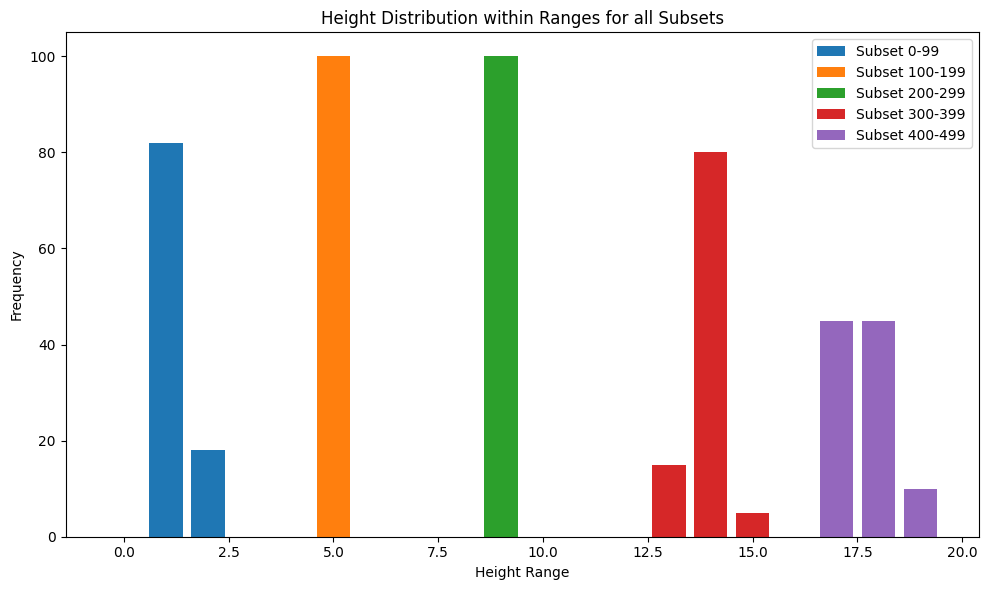

In [72]:
# # Calculate the overall minimum and maximum heights across all subsets
# min_height = np.min(heights)
# max_height = np.max(heights)
# num_subsets = 5
# subset_size = len(heights) // num_subsets
# # Define the bounds to divide the data into 4 parts
# bounds = [0, min_height, min_height + (max_height - min_height) * 0.33, 
#           min_height + (max_height - min_height) * 0.66, max_height]

# # Divide all heights into four parts based on the defined bounds
# height_ranges = np.digitize(heights, bins=bounds)

# # Count the frequency of heights in each range for each subset
# subset_height_counts = []
# for i in range(num_subsets):
#     subset_height_counts.append(np.histogram(heights[i * subset_size: (i + 1) * subset_size], bins=bounds)[0])

# # Plotting
# x_positions = np.arange(len(bounds) - 1)
# plt.figure(figsize=(10, 6))
# subset_indices = [f"{i * subset_size}-{(i + 1) * subset_size - 1}" for i in range(num_subsets)]

# for i in range(num_subsets):
#     x_shifted = x_positions + i * (len(bounds) - 1)
#     plt.bar(x_shifted, subset_height_counts[i], label=f'Subset {subset_indices[i]}')

# plt.xlabel('Height Range')
# plt.ylabel('Frequency')
# plt.title('Height Distribution within Ranges for all Subsets')
# plt.legend()
# plt.show()

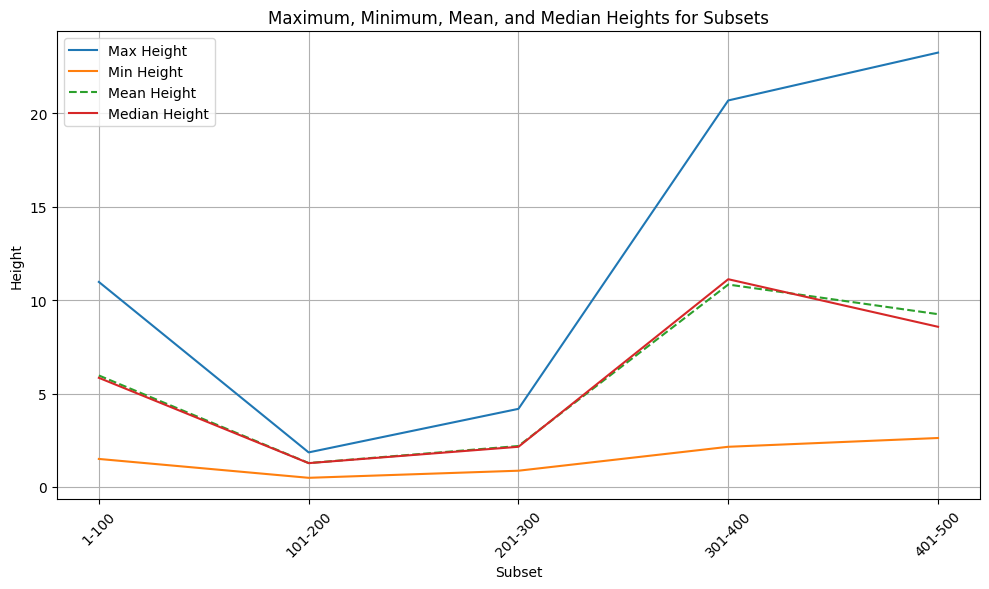

In [71]:
# # looking at the distribution of height of different object class wise

# # subset and step size definition
# num_subsets = 5
# subset_size = len(heights) // num_subsets

# # Create lists to store height statistics for each subset
# max_heights_subset = []
# min_heights_subset = []
# mean_heights_subset = []
# median_heights_subset = []

# for i in range(num_subsets):
#     subset = heights[i * subset_size : (i + 1) * subset_size]
    
#     if subset:
#         max_heights_subset.append(np.max(subset))
#         min_heights_subset.append(np.min(subset))
#         mean_heights_subset.append(np.mean(subset))
#         median_heights_subset.append(statistics.median(subset))
# subset_indices = [f"{i * subset_size + 1}-{(i + 1) * subset_size}" for i in range(num_subsets)]

# # Plot the different height-related statistics for each subset
# plt.figure(figsize=(10, 6))
# plt.plot(subset_indices, max_heights_subset, label='Max Height')
# plt.plot(subset_indices, min_heights_subset, label='Min Height')
# plt.plot(subset_indices, mean_heights_subset, label='Mean Height', linestyle='--')
# plt.plot(subset_indices, median_heights_subset, label='Median Height', linestyle='-')

# plt.xlabel('Subset')
# plt.ylabel('Height')
# plt.title('Maximum, Minimum, Mean, and Median Heights for Subsets')
# plt.legend()
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [48]:
# check if the object has a cylindrical shape
def is_cylindrical(x, y, z):
    # Calculate the covariance matrix
    covariance_matrix = np.cov(np.array([x, y, z]))
    
    # Calculate eigenvalues
    eigenvalues, _ = np.linalg.eig(covariance_matrix)
    if np.allclose(eigenvalues[0], eigenvalues[1]) and np.allclose(eigenvalues[1], eigenvalues[2]):
        return True
    else:
        return False

# check if the object has symmetry
def has_symmetry(x, y, z):
    # Calculate the centroid
    centroid = np.mean(x), np.mean(y), np.mean(z)
    distances = np.sqrt((x - centroid[0])**2 + (y - centroid[1])**2 + (z - centroid[2])**2)
    std_dev = np.std(distances)
    threshold = 0.1
    
    if std_dev < threshold:
        return True
    else:
        return False

# function to get projected areas of the item w.r.t bounding box
def get_areas(X, Y):
    X_rounded = [round(x, 0) for x in X]
    Y_rounded = [round(y, 0) for y in Y]
    x_max, x_min, y_max, y_min = max(X_rounded), min(X_rounded), max(Y_rounded), min(Y_rounded)
    x_max, x_min = x_max + 0.5, x_min - 0.5
    y_max, y_min = y_max + 0.5, y_min - 0.5
    bb_len, bb_width = abs(x_max - x_min), abs(y_max - y_min)
    bb_area = bb_len * bb_width
    string_repr = [','.join([str(x), str(y)]) for x, y in zip(X_rounded, Y_rounded)]
    projected_area = len(set(string_repr))

    return projected_area/bb_area * 100

In [49]:
# empty lists to store the features for performing classification (feature set)
max_heights = []
ground_area = []
density = []
projected_bb = []
average_height = []
planarity = []

In [50]:
# defining each feature
for item in point_cloud:

    # contains all the x, y and z values of each object
    x = []
    y = []
    z = []
    value = 0
    # contains no of points in each object
    points = []

    for value in item:
        # Extract the x, y, z values from the object
        x_cord = value[0]
        x.append(x_cord)
        y_cord = value[1]
        y.append(y_cord)
        z_cord = value[2]
        z.append(z_cord)
        points.append(value)
        value += 1

    # feature 1: calculate the max height of the object
    max_height = np.max(z)
    max_heights.append(max_height)

    min_x, max_x = np.min(x), np.max(x)
    min_y, max_y = np.min(y), np.max(y)
    min_z, max_z = np.min(z), np.max(z)

    # feature 2: calculate the ground area covered by the object through a bounding box
    area = (max_x - min_x) * (max_y - min_y)
    ground_area.append(area)

    # feature 3: calculate the density
    nr_points = len(points)
    volume = ((max_x - min_x) * (max_y - min_y) * (max_z - min_z))
    density_temp = volume/nr_points
    density.append(density_temp)

    # feature 4: ratio of projected area of object with the bounding box
    ratio_bb = get_areas(x, y)
    projected_bb.append(ratio_bb)

    # feature 5:
    z_height = np.mean(z)
    average_height.append(z_height)

    # feature 6: calculate the planarity of the object
    covariance_matrix = np.cov(np.array([x, y, z]))
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    eigenvalues.sort()
    planarity_temp = ((eigenvalues[1] + eigenvalues[0]) / (eigenvalues[0] + eigenvalues[1] + eigenvalues[2]))
    planarity.append(planarity_temp)


In [51]:
# creating a feature vector
feature_names = ['max_heights', 'ground_area', 'density', 'projected_bb', 'average_height', 'planarity']
features = pd.DataFrame({
    'Maximum height': max_heights,
    'Ground coverage area': ground_area,
    'density': density,
    'projected/bb': projected_bb,
    'average height': average_height,
    'planarity': planarity
})

In [52]:
# adding a new column to store the labels that are already given
features['label'] = ''

# assign a label to each object as they are separated at every 100th object
for i in range(5):
    label_range = range(i * 100, (i + 1) * 100)

    if i == 0:
        features.loc[label_range, 'label'] += 'building'
    elif i == 1:
        features.loc[label_range, 'label'] += 'car'
    elif i == 2:
        features.loc[label_range, 'label'] += 'fence'
    elif i == 3:
        features.loc[label_range, 'label'] += 'pole'
    elif i == 4:
        features.loc[label_range, 'label'] += 'tree'

print(features)

     Maximum height  Ground coverage area   density  projected/bb   
0         19.730000             48.731934  0.135232     91.666667  \
1          8.470000             64.715485  0.112223     78.571429   
2         15.570000            273.662312  0.228969     83.006536   
3         16.469999            354.430061  0.243781     72.474747   
4          9.750000            520.882345  0.223818     61.739130   
..              ...                   ...       ...           ...   
495       11.540000             40.565323  0.106486     75.000000   
496       15.170000            106.506569  0.198018     71.969697   
497       11.110000             36.537662  0.213788     77.083333   
498       18.910000             40.327366  0.228704     80.000000   
499       11.900000             44.167506  0.159998     78.571429   

     average height  planarity  cylindrical_shapes  symmetry     label  
0         18.003383   0.199947               False     False  building  
1          7.385178   0.3

In [68]:
# separate the features (X) and labels (y) to train and test the model
X = features.drop('label', axis=1)
y = features['label']

# Add labels to the plot
class_names = ['Building', 'Car', 'Fence', 'Pole', 'Tree']

In [69]:
# function to split the train:test data
# features used in X_train and X_test
# corresponding labels used in y_train and y_test
# stratify parameter can be used when classes are imbalanced, here they are balanced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42, stratify=y)

# scaling the feature set to improve the performance of the machine learning model
# different features have various scale, range, value so that creates an issue
scale_feature = StandardScaler()
X_train = scale_feature.fit_transform(X_train)
X_test = scale_feature.transform(X_test)

# create the SVM classifier
classify_func = svm.SVC(C=3, kernel='rbf', gamma='scale', random_state=42)

# train the classifier using the training data
classify_func.fit(X_train, y_train)

# feature importance for svm
feature_importance_svm = permutation_importance(classify_func, X_test, y_test)
feature_names = np.array(feature_names)
sorted_idx = feature_importance_svm.importances_mean.argsort()
feat_svm = feature_names[sorted_idx]
score_svm = feature_importance_svm.importances_mean[sorted_idx]

In [70]:
# Print feature names and their importance's in a sorted list
print("Feature Importance of SVM:")
for i in range(len(feat_svm)):
    print(f"{feat_svm[i]}: {round(score_svm[i],3)}")
print()

Feature Importance of SVM:
cyclindrical_shapes: 0.0
symmetry: 0.0
density: 0.057
projected_bb: 0.109
ground_area: 0.115
average_height: 0.135
max_heights: 0.299
planarity: 0.381

